<a href="https://colab.research.google.com/github/xssChauhan/CapsNets/blob/master/Document_Graph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
! ls /content/drive/MyDrive/gnn_cortex_data/

bert_embeddings		      models	train_box.txt	 val_image.txt
bilstm_bert_position_results  results	train_image.txt  val.txt
graph_data		      test	train.txt
image_embeddings	      test.txt	val_box.txt


In [ ]:
import itertools
import os

from networkx.classes import graph
import torch
# import torch_geometric


from typing import List, Tuple

import click
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# from loguru import logger
# from torch_geometric.utils import from_networkx
from tqdm import tqdm

In [ ]:
import torch

def format_pytorch_version(version):
  return version.split('+')[0]

TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)

def format_cuda_version(version):
  return 'cu' + version.replace('.', '')

CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

!pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-geometric 

from torch_geometric.utils import from_networkx
import torch_geometric

Looking in links: https://pytorch-geometric.com/whl/torch-1.11.0+cu113.html
     |████████████████████████████████| 7.9 MB 1.7 MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.11.0+cu113.html
     |████████████████████████████████| 3.5 MB 7.8 MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.11.0+cu113.html
     |████████████████████████████████| 2.5 MB 7.6 MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.11.0+cu113.html
     |████████████████████████████████| 750 kB 1.9 MB/s 
     |████████████████████████████████| 407 kB 9.1 MB/s 
  Created wheel for torch-geometric: filename=torch_geometric-2.0.4-py3-none-any.whl size=616603 sha256=db169d2e164adf559d733f04840f3c1db04d382792b5cd9cf431cea7134adc54
  Stored in directory: /root/.cache/pip/wheels/18/a6/a4/ca18c3051fcead866fe7b85700ee2240d883562a1bc70ce421
Successfully built torch-geometric


In [ ]:

def distance(src, dest):

    src_x = (src["xmax"] + src["xmin"])/2
    src_y = (src["ymax"] + src["ymin"])/2

    dest_x = (dest["xmax"] + dest["xmin"])/2
    dest_y = (dest["ymax"] + dest["ymin"])/2

    norm_x = (src_x - dest_x)/(src.width)
    norm_y = (src_y - dest_y)/(src.height)

    return np.exp(-np.sqrt(norm_x**2 + norm_y**2))


def x_distance(src, dest):
    return abs(src["xmax"] - dest["xmax"])

def y_distance(src, dest):
    return abs(src["ymax"] - dest["ymax"])

def aspect_ratio(src):
    width = abs(src["xmax"] - src["xmin"])
    height = abs(src["ymax"] - src["ymin"])
    return width / height

def relative_height(src, dest):
    src_height = abs(src["ymax"] - src["ymin"])
    dest_height = abs(dest["ymax"] - dest["ymin"])
    return dest_height / src_height

def relative_width(src, dest):
    src_width = abs(src["xmax"] - src["xmin"])
    dest_width = abs(src["ymax"] - src["ymin"])
    return dest_width / src_width

class Grapher:
    """
    Description:
            This class is used to generate:
                    1) the graph (in dictionary form) { source_node: [destination_node1, destination_node2]}
                    2) the dataframe with relative_distances 

    Inputs: The class consists of a pandas dataframe consisting of cordinates for bounding boxe and the image of the invoice/receipt. 

    """
    def __init__(self, image_df, text_df):
        
        self.text_df = text_df
        self.image_df = image_df
        
        # self.filename = filename 
        # file_path = "../../data/raw/box/" + filename + '.csv'
        # interim_path = "../../data/interim/" + filename + '.csv'
        # image_path = "../../data/raw/img/" + filename + '.jpg'
        # self.df = pd.read_csv(file_path, header=None, sep='\n')
        # self.image = cv2.imread(image_path)
        # self.df_withlabels = pd.read_csv(interim_path)

        self.label_map = {
            e:i for i,e in enumerate(self.text_df.label.unique())
        }
        self.image_df["encoded_labels"] = self.text_df.label.map(
            lambda x: self.label_map[x]
        )

    def graph_formation(self, export_graph = False):

        """
        Description:
        ===========
        Line formation:
        1) Sort words based on Top coordinate:
        2) Form lines as group of words which obeys the following:
            Two words (W_a and W_b) are in same line if:
                Top(W_a) <= Bottom(W_b) and Bottom(W_a) >= Top(W_b)
        3) Sort words in each line based on Left coordinate

        This ensures that words are read from top left corner of the image first, 
        going line by line from left to right and at last the final bottom right word of the page is read.
    
        Args: 
            df with words and cordinates (xmin,xmax,ymin,ymax)
            image read into cv2
        returns: 
            df with words arranged in orientation top to bottom and left to right, the line number for each word, index of the node connected to
            on all directions top, bottom, right and left (if they exist and satisfy the parameters provided)

        _____________________y axis______________________
        |
        |                       top    
        x axis               ___________________
        |              left | bounding box      |  right
        |                   |___________________|           
        |                       bottom 
        |
        |


        iterate through the rows twice to compare them.
        remember that the axes are inverted.
      
        """
        df = self.image_df
        """
        preprocessing the raw csv files to favorable df 
        """
        # df = df[0].str.split(',', expand=True)
        # temp = df.copy() 
        # # temp[temp.columns] = temp.apply(lambda x: x.str.strip())
        # temp.fillna('', inplace=True)
        # temp[8]= temp[8].str.cat(temp.iloc[:,9:], sep =", ") 
        # temp[temp.columns] = temp.apply(lambda x: x.str.rstrip(", ,"))
        # temp = temp.loc[:, :8]
        # temp.drop([2,3,6,7], axis=1, inplace=True)
        # temp.columns = ['xmin','ymin','xmax','ymax','Object']
        # temp[['xmin','ymin','xmax','ymax']] = temp[['xmin','ymin','xmax','ymax']].apply(pd.to_numeric)
        # df = temp 


        assert type(df) == pd.DataFrame,f'object_map should be of type \
            {pd.DataFrame}. Received {type(df)}'
        # assert type(image) == np.ndarray,f'image should be of type {np.ndarray} \
        #     . Received {type(image)}'
        
        assert 'xmin' in df.columns, '"xmin" not in object map'
        assert 'xmax' in df.columns, '"xmax" not in object map'
        assert 'ymin' in df.columns, '"ymin" not in object map'
        assert 'ymax' in df.columns, '"ymax" not in object map'
        assert 'Object' in df.columns, '"Object" column not in object map'

        #remove empty spaces both in front and behind

        #further cleaning
        # df.dropna(inplace=True)
        #sort from top to bottom
        df.sort_values(by=['ymin'], inplace=True)
        df.reset_index(drop=True, inplace=True)

        #subtracting ymax by 1 to eliminate ambiguity of boxes being in both left and right 
        df["ymax"] = df["ymax"].apply(lambda x: x - 1)
        
        master = []
        for idx, row in df.iterrows():
            #flatten the nested list 
            flat_master = list(itertools.chain(*master))
            #check to see if idx is in flat_master
            if idx not in flat_master:
                top_a = row['ymin']
                bottom_a = row['ymax']         
                #every line will atleast have the word in it
                line = [idx]         
                for idx_2, row_2 in df.iterrows():
                    #check to see if idx_2 is in flat_master removes ambiguity
                    #picks higher cordinate one. 
                    if idx_2 not in flat_master:
                    #if not the same words
                        if not idx == idx_2:
                            top_b = row_2['ymin']
                            bottom_b = row_2['ymax'] 
                            if (top_a <= bottom_b) and (bottom_a >= top_b): 
                                line.append(idx_2)
                master.append(line)

        df2 = pd.DataFrame({'words_indices': master, 'line_number':[x for x in range(1,len(master)+1)]})
        #explode the list columns eg : [1,2,3]
        df2 = df2.set_index('line_number').words_indices.apply(pd.Series).stack()\
                .reset_index(level=0).rename(columns={0:'words_indices'})
        df2['words_indices'] = df2['words_indices'].astype('int')
        #put the line numbers back to the list
        final = df.merge(df2, left_on=df.index, right_on='words_indices')
        final.drop('words_indices', axis=1, inplace=True)

        """
        3) Sort words in each line based on Left coordinate
        """
        final2 =final.sort_values(by=['line_number','xmin'],ascending=True)\
                .groupby('line_number')\
                .head(len(final))\
                .reset_index(drop=True)
    
        df = final2 
        """
        Pseudocode:
        1) Read words from each line starting from topmost line going towards bottommost line
        2) For each word, perform the following:
            - Check words which are in vertical projection with it.
            - Calculate RD_l and RD_r for each of them 
            - Select nearest neighbour words in horizontal direction which have least magnitude of RD_l and RD_r, 
            provided that those words do not have an edge in that direciton.
                    - In case, two words have same RD_l or RD_r, the word having higher top coordinate is chosen.
            - Repeat steps from 2.1 to 2.3 similarly for retrieving nearest neighbour words in vertical direction by 
            taking horizontal projection, calculating RD_t and RD_b and choosing words having higher left co-ordinate
            incase of ambiguity
            - Draw edges between word and its 4 nearest neighbours if they are available.

        Args: 
            df after lines properly aligned
            
        returns: 
            graph in the form of a dictionary, networkX graph, dataframe with 

        """

        #horizontal edges formation
        #print(df)
        df.reset_index(inplace=True)
        grouped = df.groupby('line_number')
        #for undirected graph construction
        horizontal_connections = {}
        #left
        left_connections = {}    
        #rightsp_rat
        right_connections = {}

        for _,group in grouped:
            a = group['index'].tolist()
            b = group['index'].tolist()
            horizontal_connection = {a[i]:a[i+1] for i in range(len(a)-1) }
            #storing directional connections
            right_dict_temp = {a[i]:{'right':a[i+1]} for i in range(len(a)-1) }
            left_dict_temp = {b[i+1]:{'left':b[i]} for i in range(len(b)-1) }

            #add the indices in the dataframes
            for i in range(len(a)-1):
                df.loc[df['index'] == a[i], 'right'] = int(a[i+1])
                df.loc[df['index'] == a[i+1], 'left'] = int(a[i])
        
            left_connections.update(right_dict_temp)
            right_connections.update(left_dict_temp)
            horizontal_connections.update(horizontal_connection)

        dic1,dic2 = left_connections, right_connections
                
        #verticle connections formation
        bottom_connections = {}
        top_connections = {}

        for idx, row in df.iterrows():
            if idx not in bottom_connections.keys():
                right_a = row['xmax']
                left_a = row['xmin']

                for idx_2, row_2 in df.iterrows():
                    #check for higher idx values 

                    if idx_2 not in bottom_connections.values() and idx < idx_2:
                            right_b = row_2['xmax']
                            left_b = row_2['xmin'] 
                            if (left_b <= right_a) and (right_b >= left_a): 
                                bottom_connections[idx] = idx_2                
                                top_connections[idx_2] = idx

                                #add it to the dataframe
                                df.loc[df['index'] == idx , 'bottom'] = idx_2
                                df.loc[df['index'] == idx_2, 'top'] = idx 
                                #print(bottom_connections)
                                #once the condition is met, break the loop to reduce redundant time complexity
                                break 
                        
        #combining both 
        result = {}
        dic1 = horizontal_connections
        dic2 = bottom_connections

        for key in (dic1.keys() | dic2.keys()):
            if key in dic1: result.setdefault(key, []).append(dic1[key])
            if key in dic2: result.setdefault(key, []).append(dic2[key])
        #print(result)

        G = nx.from_dict_of_lists(result)
        
        if export_graph:

            if not os.path.exists('../../figures/graphs'):
                os.makedirs('../../figures/graphs')			
           
            plot_path ='../../figures/graphs/' + self.filename + 'plain_graph' '.jpg'
            print(plot_path)
            layout = nx.kamada_kawai_layout(G)   
            layout = nx.spring_layout(G)     
            nx.draw(G, layout, with_labels=True)
            plt.savefig(plot_path, format="PNG", dpi=600)
            #plt.show()

        # connect with the interim file that has labels in it
        df['labels'] = self.text_df['label']
        self.df = df 
        # df = self.relative_distance()
        # Calculate Distances for the graph

        distances = {}
        x_dist = {}
        y_dist = {}
        asp_ratio = {}
        relative_h = {}
        relative_w = {}
        for edge in G.edges():
            src = df.iloc[edge[0]]
            dest = df.iloc[edge[1]]
            distances[edge] = {"weight": distance(src, dest)}
            x_dist[edge] = {"x_dist": x_distance(src, dest)}
            y_dist[edge] = {"y_dist": y_distance(src, dest)}
            asp_ratio[edge] = {"aspect_ratio": aspect_ratio(src)}
            relative_h[edge] = {"relative_height": relative_height(src, dest)}
            relative_w[edge] = {"relative_width": relative_width(src, dest)}
        nx.set_edge_attributes(G, distances)
        nx.set_edge_attributes(G, x_dist)
        nx.set_edge_attributes(G, y_dist)
        nx.set_edge_attributes(G, asp_ratio)
        nx.set_edge_attributes(G, relative_h)
        nx.set_edge_attributes(G, relative_w)
        return G,result, df 

    #features calculation    
    def get_text_features(self, df): 
        """
        gets text features 

        Args: df
        Returns: n_lower, n_upper, n_spaces, n_alpha, n_numeric,n_special
        """
        data = df['Object'].tolist()
        
        '''
            Args:
                df
                
            Returns: 
                character and word features
                
        '''
        special_chars = ['&', '@', '#', '(',')','-','+', 
                    '=', '*', '%', '.', ',', '\\','/', 
                    '|', ':']

        # character wise
        n_lower, n_upper, n_spaces, n_alpha, n_numeric,n_special = [],[],[],[],[],[]

        for words in data:
            lower,upper,alpha,spaces,numeric,special = 0,0,0,0,0,0
            for char in words: 
                # for upper letters 
                if char.isupper(): 
                    upper += 1
                # for white spaces
                if char.isspace():
                    spaces += 1               
                # for alphabetic chars
                if char.isalpha():
                    alpha += 1  
                # for numeric chars
                if char.isnumeric():
                    numeric += 1                            
                if char in special_chars:
                    special += 1 
                if char.islower():
                    lower += 1

            n_lower.append(lower)
            n_upper.append(upper)
            n_spaces.append(spaces)
            n_alpha.append(alpha)
            n_numeric.append(numeric)
            n_special.append(special)
            #features.append([n_lower, n_upper, n_spaces, n_alpha, n_numeric, n_digits])

        df['n_upper'],df['n_alpha'],df['n_spaces'],\
        df['n_numeric'],df['n_special'] = n_upper, n_alpha, n_spaces, n_numeric,n_special

    def relative_distance(self, export_document_graph = False):
        """ 
        1) Calculates relative distances for each node in left, right, top  and bottom directions if they exist.
        rd_l, rd_r = relative distances left , relative distances right. The distances are divided by image width
        rd_t, rd_b = relative distances top , relative distances bottom. The distances are divided by image length

        2) Exports the complete document graph for visualization

        Args: 
            result dataframe from graph_formation()
             
        returns: 
            dataframe with features and exports document graph if prompted
        """

        df, img = self.df, self.image
        image_height, image_width = self.image.shape[0], self.image.shape[1]
        plot_df = df.copy() 

        for index in df['index'].to_list():
            right_index = df.loc[df['index'] == index, 'right'].values[0]
            left_index = df.loc[df['index'] == index, 'left'].values[0]
            bottom_index = df.loc[df['indeix'] == index, 'bottom'].values[0]
            top_index = df.loc[df['index'] == index, 'top'].values[0]

            #check if it is nan value 
            if np.isnan(right_index) == False: 
                right_word_left = df.loc[df['index'] == right_index, 'xmin'].values[0]
                source_word_right = df.loc[df['index'] == index, 'xmax'].values[0]
                df.loc[df['index'] == index, 'rd_r'] = (right_word_left - source_word_right)/image_width

                """
                for plotting purposes
                getting the mid point of the values to draw the lines for the graph
                mid points of source and destination for the bounding boxes
                """
                right_word_x_max = df.loc[df['index'] == right_index, 'xmax'].values[0]
                right_word_y_max = df.loc[df['index'] == right_index, 'ymax'].values[0]
                right_word_y_min = df.loc[df['index'] == right_index, 'ymin'].values[0]

                df.loc[df['index'] == index, 'destination_x_hori'] = (right_word_x_max + right_word_left)/2
                df.loc[df['index'] == index, 'destination_y_hori'] = (right_word_y_max + right_word_y_min)/2

            if np.isnan(left_index) == False:
                left_word_right = df.loc[df['index'] == left_index, 'xmax'].values[0]
                source_word_left = df.loc[df['index'] == index, 'xmin'].values[0]
                df.loc[df['index'] == index, 'rd_l'] = (left_word_right - source_word_left)/image_width
            
            if np.isnan(bottom_index) == False:
                bottom_word_top = df.loc[df['index'] == bottom_index, 'ymin'].values[0]
                source_word_bottom = df.loc[df['index'] == index, 'ymax'].values[0]
                df.loc[df['index'] == index, 'rd_b'] = (bottom_word_top - source_word_bottom)/image_height

                """for plotting purposes"""
                bottom_word_top_max = df.loc[df['index'] == bottom_index, 'ymax'].values[0]
                bottom_word_x_max = df.loc[df['index'] == bottom_index, 'xmax'].values[0]
                bottom_word_x_min = df.loc[df['index'] == bottom_index, 'xmin'].values[0]
                df.loc[df['index'] == index, 'destination_y_vert'] = (bottom_word_top_max + bottom_word_top)/2
                df.loc[df['index'] == index, 'destination_x_vert'] = (bottom_word_x_max + bottom_word_x_min)/2
                
            if np.isnan(top_index) == False:
                top_word_bottom = df.loc[df['index'] == top_index, 'ymax'].values[0]
                source_word_top = df.loc[df['index'] == index, 'ymin'].values[0]
                df.loc[df['index'] == index, 'rd_t'] = (top_word_bottom - source_word_top)/image_height

        #replace all tne NaN values with '0' meaning there is nothing in that direction
        df[['rd_r','rd_b','rd_l','rd_t']] = df[['rd_r','rd_b','rd_l','rd_t']].fillna(0)

        if export_document_graph:
            for idx, row in df.iterrows():
        #bounding box
                cv2.rectangle(img, (row['xmin'], row['ymin']), (row['xmax'], row['ymax']), (0, 0, 255), 2)

                if np.isnan(row['destination_x_vert']) == False:
                    source_x = (row['xmax'] + row['xmin'])/2
                    source_y = (row['ymax'] + row['ymin'])/2
                    
                    cv2.line(img, 
                            (int(source_x), int(source_y)),
                            (int(row['destination_x_vert']), int(row['destination_y_vert'])), 
                            (0,255,0), 2)


                    text = "{:.3f}".format(row['rd_b'])
                    text_coordinates = ( int((row['destination_x_vert'] + source_x)/2) , int((row['destination_y_vert'] +source_y)/2))     
                    cv2.putText(img, text, text_coordinates, cv2.FONT_HERSHEY_DUPLEX, 0.4, (255,0,0), 1)

                    #text_coordinates = ((row['destination_x_vert'] + source_x)/2 , (row['destination_y_vert'] +source_y)/2)
                
                if np.isnan(row['destination_x_hori']) == False:
                    source_x = (row['xmax'] + row['xmin'])/2
                    source_y = (row['ymax'] + row['ymin'])/2

                    cv2.line(img, 
                        (int(source_x), int(source_y)),
                        (int(row['destination_x_hori']), int(row['destination_y_hori'])), \
                        (0,255,0), 2)

                    text = "{:.3f}".format(row['rd_r'])
                    text_coordinates = (int((row['destination_x_hori'] + source_x)/2) , int((row['destination_y_hori'] +source_y)/2))     
                    cv2.putText(img, text, text_coordinates, cv2.FONT_HERSHEY_DUPLEX, 0.4, (255,0,0), 1)

            # cv2.imshow("image", img)
            # cv2.waitKey(0)
            # cv2.destroyAllWindows()
                if not os.path.exists('../../figures/graphs'):
                    os.makedirs('../../figures/graphs')			
                    
                plot_path ='../../figures/graphs/' + self.filename + 'docu_graph' '.jpg'
                cv2.imwrite(plot_path, img)
   
        #drop the unnecessary columns
        df.drop(['destination_x_hori', 'destination_y_hori','destination_y_vert','destination_x_vert'], axis=1, inplace=True)
        self.get_text_features(df)
        return df




In [ ]:
from typing import List, Dict

def read_conll_file_text(filename: str, test=False) -> List[Dict]:
    '''
    Load the conll format data when the columsn
    '''
    dataset = []
    with open(filename, "r") as f:
        data = {"text":[]}
        if not test:
            data["label"] = []
        for line in f.readlines():
            if line.startswith("-DOCSTART-"):
                continue
            # import ipdb; ipdb.set_trace()
            if not line.isspace(): # If line is space then we have a new document
                line_split = line.split()
                
                input_text = line_split[0]
                data["text"].append(input_text)
                if not test:
                    label_text = line_split[-1]
                    data["label"].append(label_text)
            else:
                # print(line)
                # import pdb; pdb.set_trace()
                dataset.append(data)
                data = {"text":[]}
                if not test:
                    data["label"] = []
    return dataset


def read_conll_file_box(filename:str) -> List[Dict]:
    dataset = []

    with open(filename, "r") as f:
        data = {"text": [], "box": []}

        for line in f.readlines():
            if line.startswith("-DOCSTART-"):
                continue
            
            if not line.isspace():
                line_split = line.split()

                input_text = line_split[0]

                box = [
                    int(line_split[e])
                    for e in range(1,5)
                ]
                data["text"].append(input_text)
                data["box"].append(box)
            else:
                dataset.append(data)
                data = {"text": [], "box": []}
    
    return dataset

def read_conll_file_image(filename: str) -> List[Dict]:
    '''
    Load the conll format data when the columsn
    '''
    dataset = []
    with open(filename, "r") as f:
        data = {"text":[], "filename":[], 'box':[], "height":[], "width":[]}
        for line in f.readlines():
            if line.startswith("-DOCSTART-"):
                continue
            if not line.isspace(): # If line is space then we have a new document
                line_split = line.split()

                input_text = line_split[0]
                box = line_split[1:5]
                filename = line_split[-1]
                data["text"].append(input_text)
                data["box"].append(box)
                data["filename"].append(filename)
                data["height"].append(line_split[6])
                data["width"].append(line_split[5])
                # data["label"].append(label)
            else:
                dataset.append(data)
                
                data = {"text":[], "filename":[], 'box':[], "height":[], "width":[]}
    return dataset

In [ ]:
def make_doc_df(data: dict) -> pd.DataFrame:
    '''
    Convert Document data into a dataframe
    '''
    df =  pd.DataFrame(data)

    # Organize the coordinates of the bounding boxes into columns
    df["xmin"] = df.box.map(lambda x : float(x[0]))
    df["ymin"] = df.box.map(lambda x : float(x[1]))
    df["xmax"] = df.box.map(lambda x : float(x[2]))
    df["ymax"] = df.box.map(lambda x : float(x[3]))
    df["height"] = float(df.height.iloc[0])
    df["width"] = float(df.width.iloc[0])

    df = df.rename(columns={"text": "Object"})

    return df

def make_graphs(text_file, image_file, n=-1) -> pd.DataFrame:
    '''
    Make graphs from the dataset file, and encode the text as graph.
    Stores the text graph as Pytorch geometric data object.
    All the graphs are indexed and stored in a dataframe.
    '''
        # Read the data
    image_data = read_conll_file_image(image_file)
    text_data = read_conll_file_text(text_file)
    #data is a list of dicts

    if n != -1:
        image_data = image_data[:n]
        text_data = text_data[:n]
    
    # Make a dataframe for each of the image set
    image_dfs = map(
        lambda data: make_doc_df(data),
        tqdm(image_data)
    )

    # Make a dataframe for each of the text set
    text_dfs = map(pd.DataFrame, text_data)
    
    graph_results = map(
        lambda d: Grapher(*d).graph_formation(),
        zip(image_dfs, text_dfs)
    )

    graph_results = list(graph_results)
    graphs = [e[0] for e in graph_results] 
    graphs = [from_networkx(g) for g in graphs]
    # results = [e[1] for e in graph_results] # this is not needed
    dfs = [e[2] for e in graph_results]



    
    final_graphs = []
    final_dfs = []

    for g,d in zip(graphs, dfs):

        g.labels = d.encoded_labels.values
        g.text = d.Object.values

        final_graphs.append(g)
        final_dfs.append(d)

    return final_graphs, final_dfs

In [ ]:
graphs, dfs = make_graphs("/content/drive/MyDrive/gnn_cortex_data/train.txt", "/content/drive/MyDrive/gnn_cortex_data/train_image.txt", n=2)


100%|██████████| 2/2 [00:03<00:00,  1.81s/it]


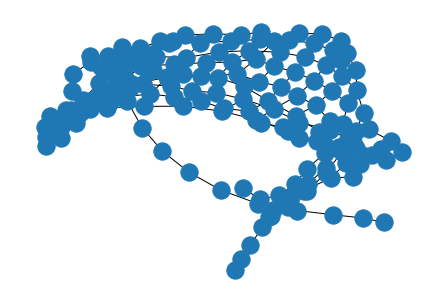

In [ ]:
from torch_geometric.utils.convert import to_networkx

nx_graph = to_networkx(graphs[0], to_undirected=True, node_attrs=["text"])

nx.draw(nx_graph)

In [ ]:

graphs[0]

Data(edge_index=[2, 568], weight=[568], x_dist=[568], y_dist=[568], aspect_ratio=[568], relative_height=[568], relative_width=[568], num_nodes=174, labels=[174], text=[174])

In [ ]:

for node,data in nx_graph.nodes(data=True):
  print(node, data)

0 {'text': 'GARDENIA'}
1 {'text': 'BAKERIES'}
2 {'text': '(KL)'}
3 {'text': 'SDN'}
4 {'text': 'BHD'}
5 {'text': '(139386'}
6 {'text': 'X)'}
7 {'text': 'LOT'}
8 {'text': '3,'}
9 {'text': 'JALAN'}
10 {'text': 'PELABUR'}
11 {'text': '23/1,'}
12 {'text': '40300'}
13 {'text': 'SHAH'}
14 {'text': 'ALAM,'}
15 {'text': 'SELANGOR.'}
16 {'text': 'TEL:'}
17 {'text': '03-'}
18 {'text': '55423228'}
19 {'text': 'FAX:03-'}
20 {'text': '55423213'}
21 {'text': 'GST'}
22 {'text': 'ID:'}
23 {'text': '000381399040'}
24 {'text': 'TAX'}
25 {'text': 'INVOICE'}
26 {'text': '/'}
27 {'text': 'ADJUSTMENT'}
28 {'text': 'NOTE'}
29 {'text': 'CASH'}
30 {'text': 'INV'}
31 {'text': 'NO.:'}
32 {'text': '7026F713'}
33 {'text': 'V'}
34 {'text': '4'}
35 {'text': 'DATE:'}
36 {'text': '26/10/2017'}
37 {'text': 'MAKASSAR'}
38 {'text': 'FRESH'}
39 {'text': 'MARKET'}
40 {'text': 'SDN'}
41 {'text': 'BHD'}
42 {'text': 'GROUND'}
43 {'text': 'FLOOR,'}
44 {'text': 'NO.'}
45 {'text': '4'}
46 {'text': '&'}
47 {'text': '6,'}
48 {'text